### G4 Semantic Segmentation

- 목표 
    - 시맨틱 세그멘테이션 테이터셋을 전처리할 수 있습니다. 
    - 시맨틱 세그멘테이션 모델을 만들고 학습할 수 있습니다. 
    - 시맨틱 세그멘테이션 모델의 결과를 시각화할 수 있습니다. 

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread 
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

#### 1. KITTI 데이터셋 구축

In [2]:
def build_augmentation(is_train=True):
    if is_train:
        return Compose([
            HorizontalFlip(p=0.5),
            RandomSizedCrop(
                min_max_height=(300, 370),
                w2h_ratio=370/1242,
                height=224, 
                width=224,
                p=0.5,
            ),
            Resize(
                width=224,
                height=224,
            )
        ])
    return Compose([
        Resize(
            width=224, 
            height=224
        )
    ])

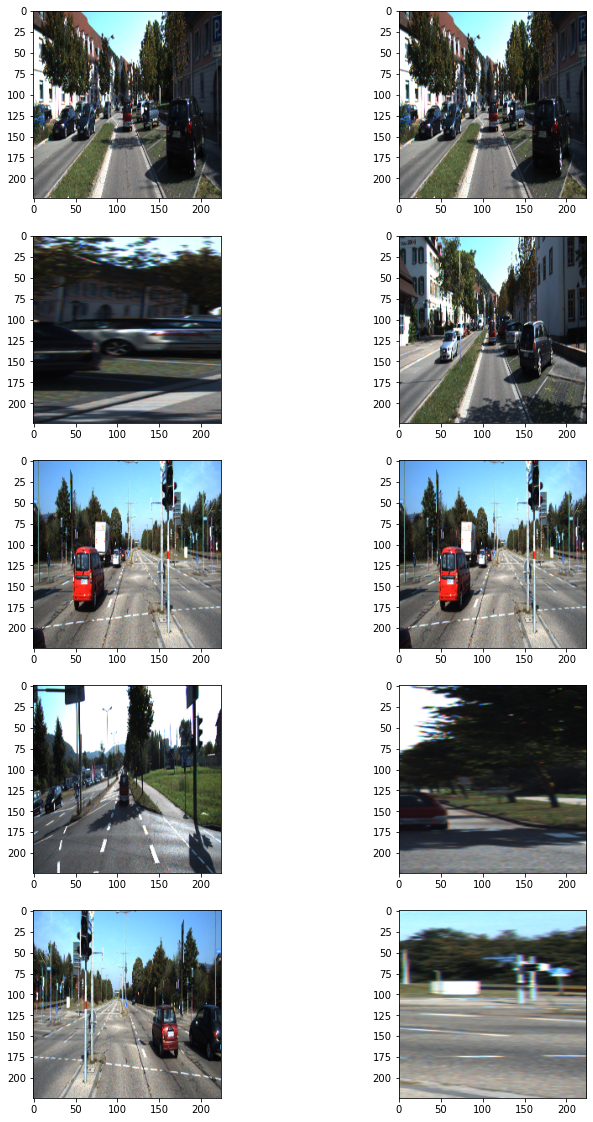

In [3]:
dir_path = os.getenv('HOME') + '/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])
    
plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, dir_path, batch_size=16, img_size=(224, 224, 3), output_size=(224, 224), is_train=True, augmentation=None):
        
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        
        self.data = self.load_dataset()
        
    def load_dataset(self):
        
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [_ for _ in zip(input_images, label_images)]
        
        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        
        return math.ceil(len(self.data) / self.batch_size)
    
    def __getitem__(self, index):
        
        batch_data = self.data[index*self.batch_size : (index + 1) * self.batch_size]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image" : _input,
                "mask" : _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"] / 255
            outputs[i] = augmented["mask"]
            return inputs, outputs
        
    def on_epoch_end(self):
        
    
        self.indexes = np.arange(len(self.data))
        if self.is_train == True:
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

# UNet 학습 데이터
train_generator = KittiGenerator(dir_path, augmentation=augmentation)
test_generator = KittiGenerator(dir_path, augmentation=test_preproc, is_train=False)

# UNet++ 학습 데이터
train_unetpp_generator = KittiGenerator(dir_path, batch_size=4, augmentation=augmentation)
test_unetpp_generator = KittiGenerator(dir_path, augmentation=test_preproc, is_train=False)

#### 4. U-Net, U-Net++ 모델 구현
- U-Net

In [6]:
def build_model_unet(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7  = concatenate([conv3, up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs, outputs=conv10)
    
    return model

- U-Net++

In [7]:
# 논문의 노드 번호를 표시해 둠 
def build_model_unetpp(input_shape=(224, 224, 3)):
    
    inputs = Input(input_shape)
    # X0,0
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # X1,0
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # X2,0
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # X3,0
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    # X4,0
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    
    drop5 = Dropout(0.5)(conv5)
    # X3,1
    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis = 3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    # X2,1
    up_conv4_7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv4))
    merge_conv3_7 = concatenate([conv3, up_conv4_7], axis = 3)
    skip_conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge_conv3_7)
    skip_conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(skip_conv7)
    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    
    # X2,2
    merge7  = concatenate([conv3, up7], axis = 3)
    merge7 = concatenate([skip_conv7, merge7], axis = 3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
        
    # X1,1
    up_conv3_8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv3))
    merge_conv2_8_1 = concatenate([conv2, up_conv3_8], axis = 3)
    skip_conv8_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge_conv2_8_1)
    skip_conv8_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(skip_conv8_1)
    # X1,2
    merge_conv2_8_2 = concatenate([conv2, skip_conv8_1], axis = 3)
    up_skip_conv7 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(skip_conv7))
    merge_sconv7_8_2 = concatenate([skip_conv8_1, up_skip_conv7], axis = 3)                                                                
    skip_conv8_2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge_sconv7_8_2)
    skip_conv8_2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(skip_conv8_2)
    # X1,3
    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    merge8 = concatenate([skip_conv8_1, merge8], axis = 3)
    merge8 = concatenate([skip_conv8_2, merge8], axis = 3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    
    # X0,1
    up_conv2_9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv2))
    merge_conv1_9 = concatenate([conv1, up_conv2_9], axis = 3)
    skip_conv9_1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge_conv1_9)
    skip_conv9_1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(skip_conv9_1)
    
    # X0,2
    merge_conv1_9 = concatenate([conv1, skip_conv9_1], axis = 3)
    up_skip_conv8_1 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(skip_conv8_1))
    merge_sconv8_1_9 = concatenate([merge_conv1_9, up_skip_conv8_1], axis = 3)
    skip_conv9_2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge_sconv8_1_9)
    skip_conv9_2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(skip_conv9_2)
    
    # X0,3
    merge_conv1_9_2 = concatenate([conv1, skip_conv9_2], axis = 3)
    up_skip_conv8_2 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(skip_conv8_2))
    merge_sconv8_2 = concatenate([merge_conv1_9_2, up_skip_conv8_2], axis = 3)
    skip_conv9_3 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge_sconv8_2)
    skip_conv9_3 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(skip_conv9_3)
    # X0,4
    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis = 3)
    merge9 = concatenate([merge9, skip_conv9_1], axis = 3)
    merge9 = concatenate([merge9, skip_conv9_2], axis = 3)
    merge9 = concatenate([merge9, skip_conv9_3], axis = 3)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs, outputs=conv10)
    
    return model

#### 3. 모델 학습
- Model : U-Net
- BatchSize : 16
- Epochs : 100

In [75]:
model = build_model_unet()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
    generator=train_generator, 
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100, 
)

model_path = dir_path + '/seg_model_unet.h5'
model.save(model_path)

Epoch 1/100
11/11 [==============================] - 6s 585ms/step - loss: 0.6776 - val_loss: 0.6308
Epoch 2/100
11/11 [==============================] - 6s 571ms/step - loss: 0.2048 - val_loss: 0.0480
Epoch 3/100
11/11 [==============================] - 6s 566ms/step - loss: 0.0298 - val_loss: 0.0268
Epoch 4/100
11/11 [==============================] - 6s 566ms/step - loss: 0.0365 - val_loss: 0.0309
Epoch 5/100
11/11 [==============================] - 6s 567ms/step - loss: 0.0405 - val_loss: 0.0303
Epoch 6/100
11/11 [==============================] - 6s 568ms/step - loss: 0.0308 - val_loss: 0.0244
Epoch 7/100
11/11 [==============================] - 6s 570ms/step - loss: 0.0286 - val_loss: 0.0302
Epoch 8/100
11/11 [==============================] - 6s 571ms/step - loss: 0.0267 - val_loss: 0.0233
Epoch 9/100
11/11 [==============================] - 6s 571ms/step - loss: 0.0363 - val_loss: 0.0284
Epoch 10/100
11/11 [==============================] - 6s 570ms/step - loss: 0.0221 - val_lo

- Model : U-Net++
- BatchSize : 4
- Epochs : 100

In [61]:
model_unetpp = build_model_unetpp()
model_unetpp.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model_unetpp.fit_generator(
    generator=train_unetpp_generator, 
    validation_data=test_unetpp_generator,
    steps_per_epoch=len(train_unetpp_generator),
    epochs=100, 
)

model_unetpp_path = dir_path + '/seg_model_unetpp.h5'
model_unetpp.save(model_unetpp_path)

Epoch 1/100
43/43 [==============================] - 7s 161ms/step - loss: 0.4323 - val_loss: 0.0367
Epoch 2/100
43/43 [==============================] - 7s 154ms/step - loss: 0.1112 - val_loss: 0.0231
Epoch 3/100
43/43 [==============================] - 7s 154ms/step - loss: 0.0899 - val_loss: 0.0297
Epoch 4/100
43/43 [==============================] - 7s 154ms/step - loss: 0.1055 - val_loss: 0.0314
Epoch 5/100
43/43 [==============================] - 7s 154ms/step - loss: 0.0824 - val_loss: 0.0209
Epoch 6/100
43/43 [==============================] - 7s 154ms/step - loss: 0.0797 - val_loss: 0.0236
Epoch 7/100
43/43 [==============================] - 7s 154ms/step - loss: 0.0869 - val_loss: 0.0244
Epoch 8/100
43/43 [==============================] - 7s 154ms/step - loss: 0.0763 - val_loss: 0.0221
Epoch 9/100
43/43 [==============================] - 7s 154ms/step - loss: 0.0645 - val_loss: 0.0199
Epoch 10/100
43/43 [==============================] - 7s 154ms/step - loss: 0.0637 - val_lo

In [8]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU :%f' % iou_score)
    return iou_score

In [9]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

#### 4. 결과

IoU :0.579684


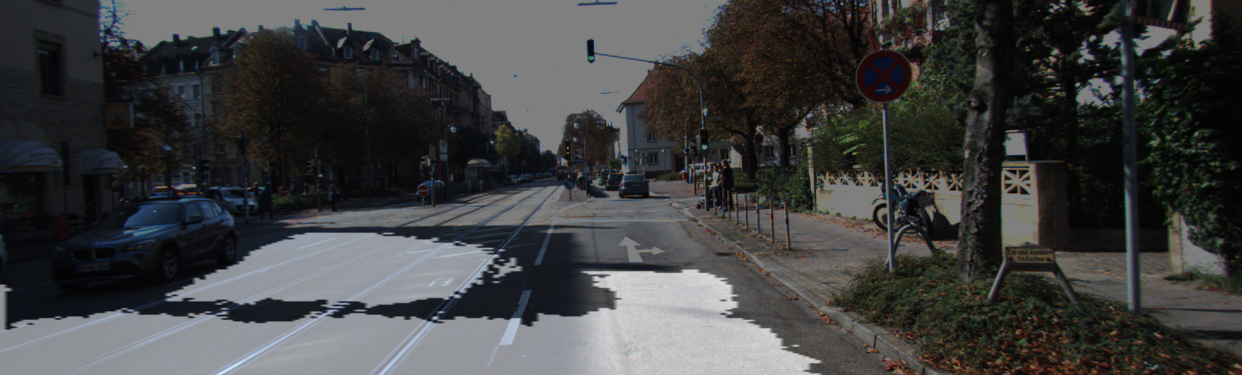

In [10]:
i = 1 # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

output

IoU :0.843636


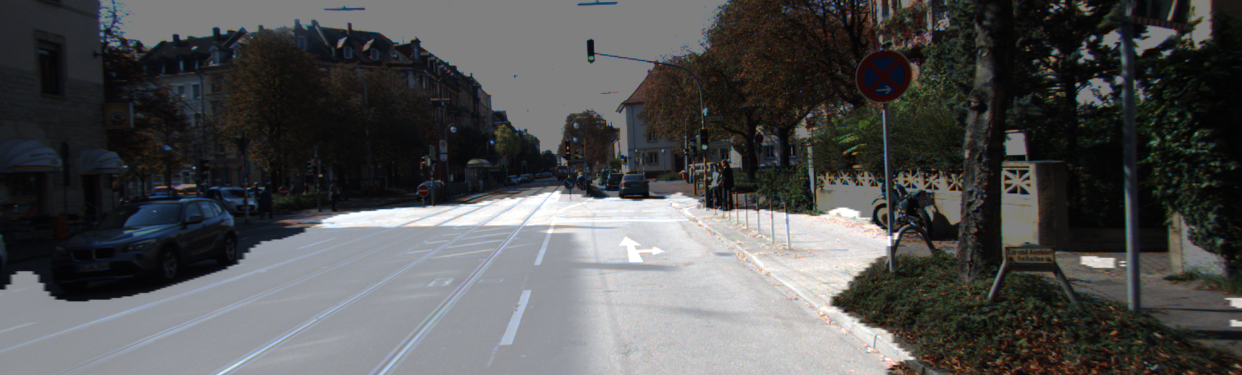

In [65]:
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model_unetpp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

output

#### 5. 고찰
- U-Net++모델은 U-Net모델과 비교했을 때 많은 변화가 없지만 좋은 성능을 내는 것을 확인할 수 있었다. 
- 논문을 구현할때 모델과 똑같이 구현하는 것보다는 사용하는 데이터나 목적에 따라 조금씩 변경을 하여주며 여러가지 테스트를 하ㅇ